C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 10, Training Loss: 0.8594027757644653, Validation Loss: 1.0568302869796753
Epoch 20, Training Loss: 0.566173791885376, Validation Loss: 0.6136447191238403
Epoch 30, Training Loss: 0.4431670606136322, Validation Loss: 0.5355113744735718
Epoch 40, Training Loss: 0.3744795322418213, Validation Loss: 0.4592033922672272
Epoch 50, Training Loss: 0.34801214933395386, Validation Loss: 0.46673181653022766
Epoch 60, Training Loss: 0.31154584884643555, Validation Loss: 0.4579709768295288
Epoch 70, Training Loss: 0.27486494183540344, Validation Loss: 0.4465663433074951
Epoch 80, Training Loss: 0.2582305371761322, Validation Loss: 0.45964521169662476
Epoch 90, Training Loss: 0.23215889930725098, Validation Loss: 0.4747636318206787
Epoch 100, Training Loss: 0.21733471751213074, Validation Loss: 0.4915508031845093


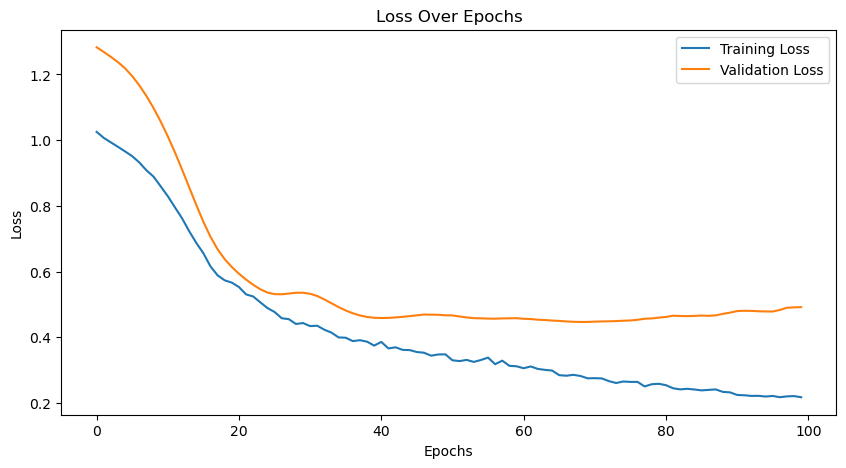

Validation Loss: 0.4915508031845093
RMSE on Validation Set: 0.70110684633255


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

# Load datasets
train_df = pd.read_csv('./data/house-train.csv')
test_df = pd.read_csv('./data/house-test.csv')

# Define categorical features for one-hot encoding
categorical_features = ['Neighborhood', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 
                        'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']

# Combine train and test data for consistent preprocessing
combined_df = pd.concat([train_df, test_df], sort=False)

# Apply one-hot encoding
one_hot_encoder = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features)],
    remainder='passthrough')

combined_df_encoded = one_hot_encoder.fit_transform(combined_df[categorical_features])
encoded_feature_names = one_hot_encoder.named_transformers_['onehot'].get_feature_names_out(categorical_features)
combined_df_encoded = pd.DataFrame(combined_df_encoded, columns=encoded_feature_names)

# Add the SalePrice back to the DataFrame
combined_df_encoded['SalePrice'] = combined_df['SalePrice'].values

# Handling missing values in the target (SalePrice might have NaN due to concatenation)
combined_df_encoded = combined_df_encoded.dropna(subset=['SalePrice'])

# Split back into training and testing data
train_df_encoded = combined_df_encoded.iloc[:len(train_df)]
test_df_encoded = combined_df_encoded.iloc[len(train_df):]

X = train_df_encoded.drop('SalePrice', axis=1)
y = train_df_encoded['SalePrice']

# Splitting the training data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the target variable (SalePrice)
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))

# Define a more complex MLP model
class ComplexMLP(nn.Module):
    def __init__(self, input_size):
        super(ComplexMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = ComplexMLP(input_size=X_train.shape[1])

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)# best LR 0.0001 for 150 epoch

# Training loop with loss tracking
train_losses = []
val_losses = []
num_epochs = 100  # Increased number of epochs for more complex training from 150 to 100 test

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate model performance on validation set
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor)
    val_loss = criterion(val_predictions, y_val_tensor)
    print('Validation Loss:', val_loss.item())

# Calculating RMSE for model performance
rmse_val = torch.sqrt(val_loss).item()
print(f'RMSE on Validation Set: {rmse_val}')
